# Let's try analyzeing ATECO in the region


In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import folium
import geopandas as gpd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import math
import folium
import datetime
from os import listdir
from os.path import isfile, join

from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages

import statsmodels.api as sm
from stargazer.stargazer import Stargazer

In [2]:
ateco2007 = pd.read_csv('quake_data/Ateco2007.csv', sep=';')
ateco1 = ateco2007[ateco2007['Codice Ateco 2007'].str.len()==1].reset_index().drop(['index','Codice Ateco 2007'],axis=1)
ateco1.columns = ['ateco1','desc1']
ateco2 = ateco2007[ateco2007['Codice Ateco 2007'].str.len()==2].reset_index().drop('index',axis=1)
ateco2.columns = ['ateco1','ateco2','desc2']
ateco = pd.merge(ateco1,ateco2)
ateco

,ateco1,desc1,ateco2,desc2
0,A,"AGRICOLTURA, SILVICOLTURA E PESCA",01,COLTIVAZIONI AGRICOLE E PRODUZIONE DI PRODOTTI...
1,A,"AGRICOLTURA, SILVICOLTURA E PESCA",02,SILVICOLTURA ED UTILIZZO DI AREE FORESTALI
2,A,"AGRICOLTURA, SILVICOLTURA E PESCA",03,PESCA E ACQUACOLTURA
3,B,ESTRAZIONE DI MINERALI DA CAVE E MINIERE,05,ESTRAZIONE DI CARBONE (ESCLUSA TORBA)
4,B,ESTRAZIONE DI MINERALI DA CAVE E MINIERE,06,ESTRAZIONE DI PETROLIO GREGGIO E DI GAS NATURALE
...,...,...,...,...
83,S,ALTRE ATTIVITÀ DI SERVIZI,95,RIPARAZIONE DI COMPUTER E DI BENI PER USO PERS...
84,S,ALTRE ATTIVITÀ DI SERVIZI,96,ALTRE ATTIVITÀ DI SERVIZI PER LA PERSONA
85,T,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...
86,T,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,98,PRODUZIONE DI BENI E SERVIZI INDIFFERENZIATI P...


In [3]:
# aida_crateri3.csv contiene proprio le aziende create prima del terremoto e che erano attive al momento del terremoto

aida = pd.read_csv('quake_data/aida_crateri3.csv')
aida = aida[['Comune','Ricavi delle vendite migl EUR Ultimo anno disp.','Dipendenti Ultimo anno disp.','Stato giuridico','ateco2']]
aida.columns = ['Comune','ricavi','dipendenti','stato','ateco2']

aida['ateco2'] = aida['ateco2'].astype('string')
m = aida['ateco2'].str.len().max()
aida['ateco2'] = aida['ateco2'].str.rjust(m, '0').astype('str').str[0:2]

aida[aida['ateco2']=='02']

,Comune,ricavi,dipendenti,stato,ateco2
115,Fabriano,2010.0,3,Attiva,02
183,Fabriano,601.0,0,Attiva,02
190,Fabriano,537.0,42,Fallita,02
249,Fabriano,250.0,30,Cessata (Fusione),02
434,Fabriano,1.0,2,Attiva,02
...,...,...,...,...,...
52484,Fara in Sabina,160.0,3,Attiva,02
52750,Caramanico Terme,136.0,1,Attiva,02
52911,Magliano de' Marsi,132.0,5,Attiva,02
53167,Massa d'Albe,0.0,0,Attiva,02


In [4]:
aida_ateco = pd.merge(aida.astype('str') , ateco.astype('str') , how='left', on='ateco2')
aida_ateco.loc[aida_ateco['ricavi'] == 'n.d.','ricavi'] = np.nan
aida_ateco.loc[aida_ateco['dipendenti'] == 'n.d.','dipendenti'] = np.nan
aida_ateco['ricavi'] = aida_ateco['ricavi'].astype('float')
aida_ateco['dipendenti'] = aida_ateco['dipendenti'].astype('float')
aida_ateco[aida_ateco['ateco1']=='A']
aida_ateco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53289 entries, 0 to 53288
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Comune      53289 non-null  object 
 1   ricavi      53289 non-null  float64
 2   dipendenti  53289 non-null  float64
 3   stato       53289 non-null  object 
 4   ateco2      53289 non-null  object 
 5   ateco1      53289 non-null  object 
 6   desc1       53289 non-null  object 
 7   desc2       53289 non-null  object 
dtypes: float64(2), object(6)
memory usage: 3.7+ MB


In [5]:
aida_ateco.loc[aida_ateco['Comune']=='Acciano',:]

,Comune,ricavi,dipendenti,stato,ateco2,ateco1,desc1,desc2
52738,Acciano,120.0,2.0,Attiva,46,G,COMMERCIO ALL'INGROSSO E AL DETTAGLIO; RIPARAZ...,COMMERCIO ALL'INGROSSO (ESCLUSO QUELLO DI AUTO...
52739,Acciano,38.0,1.0,Attiva,81,N,"NOLEGGIO, AGENZIE DI VIAGGIO, SERVIZI DI SUPPO...",ATTIVITÀ DI SERVIZI PER EDIFICI E PAESAGGIO
52740,Acciano,8.0,0.0,Attiva,46,G,COMMERCIO ALL'INGROSSO E AL DETTAGLIO; RIPARAZ...,COMMERCIO ALL'INGROSSO (ESCLUSO QUELLO DI AUTO...


In [9]:
vc = aida_ateco['desc1'].value_counts().to_frame()
vc['p'] = vc['desc1']/vc['desc1'].sum()*100
vc

,desc1,p
COMMERCIO ALL'INGROSSO E AL DETTAGLIO; RIPARAZIONE DI AUTOVEICOLI E MOTOCICLI,9852,18.487868
ATTIVITÀ MANIFATTURIERE,9660,18.127569
COSTRUZIONI,9443,17.720355
ATTIVITA' IMMOBILIARI,6251,11.730376
"ATTIVITÀ PROFESSIONALI, SCIENTIFICHE E TECNICHE",3505,6.577342
ATTIVITÀ DEI SERVIZI DI ALLOGGIO E DI RISTORAZIONE,3074,5.768545
"NOLEGGIO, AGENZIE DI VIAGGIO, SERVIZI DI SUPPORTO ALLE IMPRESE",2197,4.122802
SERVIZI DI INFORMAZIONE E COMUNICAZIONE,2085,3.912627
TRASPORTO E MAGAZZINAGGIO,1594,2.991236
"AGRICOLTURA, SILVICOLTURA E PESCA",1403,2.632814


In [ ]:
sectors = aida_ateco['desc1'].value_counts()[0:10].index
aida_ateco = aida_ateco.loc[aida_ateco['desc1'].isin(sectors),:]

In [ ]:

def ateco_groupby(df):
    aggregation = {'Comune':[np.size],'ricavi':[np.sum],'dipendenti':[np.sum]}
    ateco0 = df.groupby(['Comune']).aggregate(aggregation).reset_index()
    ateco0.columns = ['Comune','n_imprese','tot_ricavi','tot_dipendenti']
    ateco1 = df.groupby(['Comune', 'ateco1','desc1']).aggregate(aggregation).reset_index()
    ateco1.columns = ['Comune','ateco1','desc1','n_imprese','tot_ricavi','tot_dipendenti']
    ateco2 = df.groupby(['Comune','ateco2','desc2']).aggregate(aggregation).reset_index()
    ateco2.columns = ['Comune','ateco2','desc2','n_imprese','tot_ricavi','tot_dipendenti']
    return (ateco0,ateco1,ateco2)

imprese_ateco0,imprese_ateco1,imprese_ateco2 = ateco_groupby(aida_ateco)

imprese_ateco0.loc[imprese_ateco0['Comune']=='Acciano',:]

In [ ]:
imprese_ateco1.loc[imprese_ateco1['Comune']=='Acciano',:]

In [ ]:
imprese_ateco2.loc[imprese_ateco2['Comune']=='Acciano',:]

In [ ]:
# composizione dei comuni, voglio una cosa del tipo: il comune X è al 50% agrigolo...

denom = imprese_ateco0[['Comune','n_imprese','tot_ricavi']]
denom.columns = ['Comune','n_imprese0','tot_ricavi0']

imprese_ateco2 = imprese_ateco2.merge(denom)
imprese_ateco2['p_imprese'] = imprese_ateco2['n_imprese'] / imprese_ateco2['n_imprese0']
imprese_ateco2['p_ricavi'] = imprese_ateco2['tot_ricavi'] / imprese_ateco2['tot_ricavi0']

imprese_ateco1 = imprese_ateco1.merge(denom)
imprese_ateco1['p_imprese'] = imprese_ateco1['n_imprese'] / imprese_ateco1['n_imprese0']
imprese_ateco1['p_ricavi'] = imprese_ateco1['tot_ricavi'] / imprese_ateco1['tot_ricavi0']
imprese_ateco1.loc[imprese_ateco1['Comune']=='Acciano',:]

In [ ]:
value = 'p_ricavi'
imprese_ateco_wide = imprese_ateco1.pivot(index='Comune',columns='desc1')[value].fillna(0)
imprese_ateco_wide.columns

In [ ]:
value = 'p_ricavi'
imprese_ateco_wide = imprese_ateco1.pivot(index='Comune',columns='desc1')[value].fillna(0)
#imprese_ateco_wide = imprese_ateco2.pivot(index='Comune',columns='ateco2')[value].fillna(0)


ateco_names = ['AGRICOLTURE','REAL ESTATE','HOSPITALITY','MANUFACTURING','TECH SERVICES','WHOLE/RETAIL SALES','CONSTRUCTIONS','BUSINESS SUPPORT SERVICES','COMMUNICATION AND INFORMATION SERV.','LOGISTICS']

'''
ateco_names = ['AGRICOLTURE', 'OTHER','PUBLIC ADMINISTRATION','REAL ESTATE',
       'SPORT AND ENTERTAINMENT','HOSPITALITY',
       'FINANCIAL SERVICES', 'MANUFACTURING','TECH SERVICES',
       'WHOLE/RETAIL SALES','CONSTRUCTIONS', 'MINING',
       'WATER AND WASTE DISPOSAL','UTILITIES',
       'EDUCATION','BUSINESS SUPPORT SERVICES',
       'EXTRATERRITORIAL ORG.','SOCIAL WELFARE',
       'COMMUNICATION AND INFORMATION SERV.','LOGISTICS']
'''


imprese_ateco_wide.columns = ateco_names
imprese_ateco_wide = imprese_ateco_wide.reset_index()
imprese_ateco_wide.head(2)

In [ ]:
imprese_ateco_wide.to_csv('quake_data/imprese_ateco_wide.csv',index=False)

# Analysis of Failed companies

In [2]:
aida = pd.read_csv('quake_data/aida_raw.csv')
aida = aida[aida['Cratere Centro Italia 2016']==1]
aida = aida[['Comune','Ricavi delle vendite migl EUR Ultimo anno disp.','Dipendenti Ultimo anno disp.','Stato giuridico','ateco2','costituzione','ubilancio']]
aida.columns = ['Comune','ricavi','dipendenti','stato','ateco2','costituzione','ubilancio']
aida = aida.loc[aida['costituzione'] < 2015,:]
aida = aida.loc[aida['ubilancio'] >= 2015,:]
#aida = aida.loc[aida['dipendenti'] > 0,:]
#aida = aida.loc[aida['ricavi'] > 0,:]
aida.loc[aida['Comune']=='Amatrice']


#imprese_pre_terremoto = aida[(aida['costituzione'] < 2015) & (aida['ubilancio'] >= 2015)]

,Comune,ricavi,dipendenti,stato,ateco2,costituzione,ubilancio
11060,Amatrice,4991.0,22,Attiva,47,1987,2020
11062,Amatrice,1848.0,8,Attiva,47,1997,2019
11063,Amatrice,518.0,8,Attiva,41,2005,2020
11064,Amatrice,481.0,5,Attiva,41,1992,2020
11065,Amatrice,476.0,6,Attiva,47,2012,2020
11067,Amatrice,407.0,4,Attiva,43,2014,2019
11069,Amatrice,330.0,4,Attiva,41,2013,2020
11071,Amatrice,276.0,0,Attiva,41,2005,2020
11074,Amatrice,220.0,4,Attiva,25,2014,2020
11076,Amatrice,209.0,8,Attiva,41,2009,2020


In [6]:
aida = pd.read_csv('quake_data/aida_crateri3.csv')
aida = aida[['Comune','Ricavi delle vendite migl EUR Ultimo anno disp.','Dipendenti Ultimo anno disp.','Stato giuridico','ateco2','ubilancio']]
aida.columns = ['Comune','ricavi','dipendenti','stato','ateco2','ubilancio']


In [8]:
aida.loc[aida['Comune']=='Amatrice',:]

,Comune,ricavi,dipendenti,stato,ateco2,ubilancio
5573,Amatrice,4991.0,22,Attiva,47,2020
5574,Amatrice,1848.0,8,Attiva,47,2019
5575,Amatrice,518.0,8,Attiva,41,2020
5576,Amatrice,481.0,5,Attiva,41,2020
5577,Amatrice,476.0,6,Attiva,47,2020
5578,Amatrice,407.0,4,Attiva,43,2019
5579,Amatrice,330.0,4,Attiva,41,2020
5580,Amatrice,276.0,0,Attiva,41,2020
5581,Amatrice,220.0,4,Attiva,25,2020
5582,Amatrice,209.0,8,Attiva,41,2020


In [11]:
#failed = aida.loc[(aida['stato']!='Attiva')|(aida['dipendenti']==0)|(aida['ricavi']==0),:]
#failed = aida.loc[(aida['stato']!='Attiva'),:]
failed = aida.loc[(aida['ubilancio']<2020),:]
#failed = aida.loc[(aida['survived']==0),:]

failed.loc[failed['Comune']=='Amatrice']

,Comune,ricavi,dipendenti,stato,ateco2,ubilancio
5574,Amatrice,1848.0,8,Attiva,47,2019
5578,Amatrice,407.0,4,Attiva,43,2019
5585,Amatrice,183.0,2,Attiva,10,2019
5587,Amatrice,57.0,0,Attiva,10,2019
5588,Amatrice,23.0,0,Attiva,82,2018
5590,Amatrice,9.0,0,Cessata (In liquidazione),1,2019
5592,Amatrice,0.0,0,Attiva,41,2017
5594,Amatrice,0.0,0,Cessata (In liquidazione),47,2015
5595,Amatrice,0.0,0,Attiva,41,2018
5596,Amatrice,0.0,0,Attiva,41,2019


In [12]:
def ateco0_groupby(df,p=''):
    aggregation = {'Comune':[np.size],'ricavi':[np.sum],'dipendenti':[np.sum]}
    ateco0 = df.groupby(['Comune']).aggregate(aggregation).reset_index()
    ateco0.columns = ['Comune',p+'n_imprese',p+'tot_ricavi',p+'tot_dipendenti']
    return ateco0

ateco0 = ateco0_groupby(aida)
failed = ateco0_groupby(failed,'F')
f = ateco0.merge(failed,how='left').fillna(0)
f['failed'] = np.where(f['Fn_imprese']>0, f['Fn_imprese']/f['n_imprese'], 0)
f['failed_ricavi'] = np.where(f['Ftot_ricavi']>0, f['Ftot_ricavi']/f['tot_ricavi'], 0)
f['failed_dipendenti'] = np.where(f['Ftot_dipendenti']>0, f['Ftot_dipendenti']/f['tot_dipendenti'], 0)
f=f[['Comune','n_imprese','tot_ricavi','tot_dipendenti','failed','failed_ricavi','failed_dipendenti']]
f.to_csv('quake_data/failed.csv',index=False)
f

,Comune,n_imprese,tot_ricavi,tot_dipendenti,failed,failed_ricavi,failed_dipendenti
0,Abbateggio,2,205.0,9,1.000000,1.000000,1.000000
1,Acciano,3,166.0,3,1.000000,1.000000,1.000000
2,Accumoli,10,1844.0,18,0.500000,0.407267,0.444444
3,Acqualagna,51,22745.0,360,0.235294,0.015344,0.130556
4,Acquapendente,66,60150.0,221,0.393939,0.068728,0.253394
...,...,...,...,...,...,...,...
564,Villa Sant'Angelo,1,109.0,1,1.000000,1.000000,1.000000
565,Villamagna,28,27412.0,372,0.250000,0.253356,0.459677
566,Visso,12,39715.0,174,0.166667,0.011859,0.034483
567,Viterbo,1448,1164848.0,7195,0.366713,0.111290,0.173871


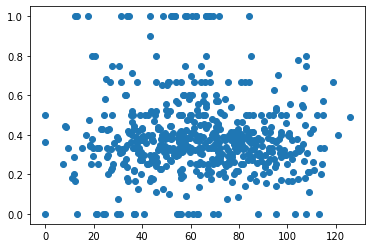

In [15]:
distance = pd.read_csv('quake_data/distance_from_epicenter.csv', sep=',')
f = f.merge(distance)
plt.scatter(f['Distance_from_epicenter'],f['failed'])
#plt.scatter(f['Distance_from_epicenter'],f['failed_ricavi'])
#plt.scatter(f['Distance_from_epicenter'],f['failed_dipendenti'])
plt.show()